# How do you write test cases for image processing?

And by the way, what's a test case?

We can guess that it might be important to test things. Testing software presents some interesting challenges, although it may seem trivial at first glance.

In [3]:
# Make sure multiplication works
2 * 2 == 4

True

Duh. But how might you test _this_ example below?

In [4]:
# Make sure numpy's random number generator works
import numpy as np
rand_nums = np.random.randn(10)
print(rand_nums)

[-0.73825866 -1.36283085 -0.12391159  0.24363398  0.16430513  1.719747
 -0.32166351 -0.76636494  0.48526242 -0.22602761]


In [5]:
%matplotlib inline

C:\Users\Sukrit\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


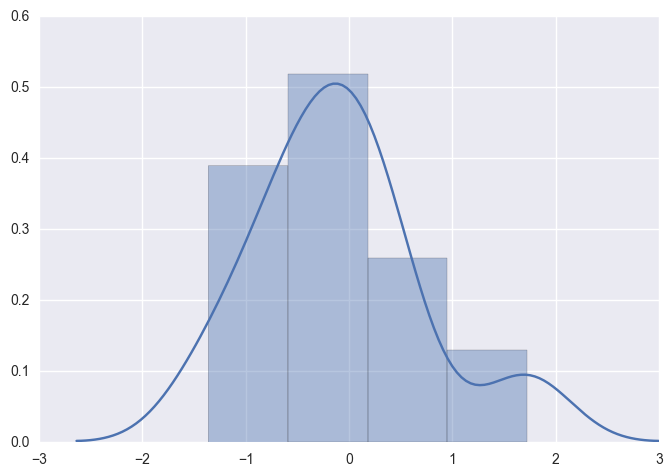

In [6]:
# Do they look random?
import seaborn as sns
sns.distplot(rand_nums)

This probably won't do. What if every number alternated even-odd? We would need _a lot_ of ways of looking at the data to rule out any weird behavior. It's easy to encounter a similar situation when writing image processing pipelines.

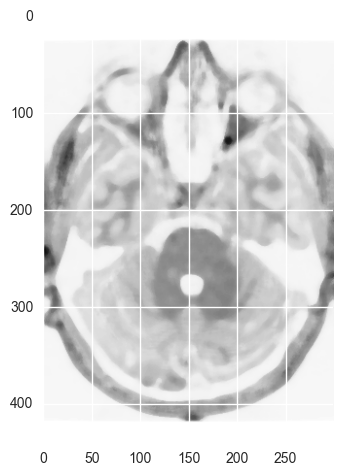

In [7]:
# Testing denoising procedure.
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.io import imread
import matplotlib.pyplot as plt

image = imread("../data/gvwilson-brain-2014/HA_1001_t1axial1.png")
filtered = median(image, disk(5))
plt.imshow(filtered)

Did the filter work? Are you sure?

What makes testing image processing pipelines hard is that we are usually interested in whether or not a function solves a problem rather than produces a particular numerical result.

- Does my filter make my image look less noisy
- Did my background subtraction preserve the foreground
- Did my clustering find things that look like cells?

Some of these tests we are tempted to preform using visual inspection, e.g. "look less noisy", but this isn't something you can test. Typically developing a pipeline is an interative process of checking results on a small subset of images, then changing your experiment or code, checking, etc. Eventually one experimental method and one set of software parameters work for what you're trying to do.

So what does it mean to write a test? Why bother if, by definition, once you're done writing code you know the code works pretty well for your experiment?

## Why do we write tests? 

Imagine that you tune an image processing pipeline to find cells in an image and it works really nicely on your labmate's set of 2000 images. You want to use it on your images which came from the same experimental setup. You even verify that it runs on the first 10 images of your set of 10000. However for your paper's figures, you want to produce a list of sorted cells sizes, normalized by the biggest cell size, so you throw in a bit of code to do that called `sort_and_scale`.

In [8]:
def sort_and_scale(regions):
    def get_size_of_region(reg):
        return reg.area

    regions_by_size = sorted(regions, key=get_size_of_region)
    biggest_region = regions_by_size[-1] # last item in a sorted list is the biggest!
    normalized_sizes = [region.area / biggest_region.area for region in regions]
    return normalized_sizes

**Exercise** Will this code run? Will it do what you expect it to? Will it always? What line(s) are problematic?

Consider what happens when `regions = []`, i.e. no regions were identified (maybe you used too much erosion)!

So you would run your code and head to the pub, discovering next morning that the code you had running overnight didn't get past the 16th image.

**We don't write tests against variations in the input data; we write tests to protect us against unexpected consequences of variation in the code itself while the input is fixed!**

This takes the form of writing code that checks the performance of your pipeline before it's run. We're not doing this because we think we made mistakes... _yet_. If we made mistakes in the code, we're likely to make mistakes in the tests we write just after! The reason we write tests is because next week we may decided we want to change the code, and we may introduce regressions i.e. losses in correctness, capabilities, or performance.

**Exercise** Write some code to run after any changes in the code that would allow us to discover the problem above.

In [9]:
if sort_and_scale([]) is not []:
    print("sort_and_scale did not handle an empty region list properly")

IndexError: list index out of range

## Language features and formalisms for testing 

The `if` statement was designed to control flow through a functioning program, not as a method of testing. Consider what would happen if we ran the above. Python would get to `if sort_and_scale([])...` and would actually run `sort_and_scale([])`, producing an error before the `if` statement even finished!

When dealing in errors, you must use `try` and `except`. `try` just says "if the following code produces an error, jump ahead to whatever I wrote in '`except`' rather than immediately halt".

In [12]:
try:
    sort_and_scale([])
except IndexError:
    print("sort_and_scale did not handle an empty region list properly")

sort_and_scale did not handle an empty region list properly


For tests where we want a specific output rather than lack of failure, we can use `assert`, which acts like an `if`, but automatically raises an error if a failure occurs. You can then handle this error with a `try` block if you like.

In [13]:
assert sort_and_scale([]) == []

IndexError: list index out of range

**Excercise** Use assertion to verify that dividing two numpy integers returns a value of integer type

In [14]:
a = np.array([1], dtype=int)
b = np.array([2], dtype=int)
assert (a / b).dtype == int

AssertionError: 

## Tools for testing images 

Let's recall that testing is for verifying that code works as expected when _input stays fixed_. So one way to test an image processing pipeline is to take an image you used to develop the pipeline, apply some step of the pipeline, save the result. Then the actual test runs the current code and verifies that it's output looks like the saved output. Of course, if you intend the results to change, then you must account for this.

In [15]:
def preprocessing_stage(image):
    # Denoise
    from skimage.filters.rank import median
    from skimage.morphology import disk
    
    denoised = median(image, disk(5))
    
    
    # Smooth
    from skimage.filters import gaussian
    
    smoothed = gaussian(denoised, sigma=2)
    
    return smoothed

C:\Users\Sukrit\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


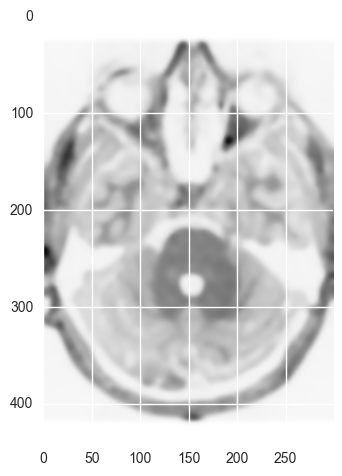

In [16]:
# Set up the test. 
# Do this when you finish the first working draft of your function
from skimage.io import imread, imsave
test_input = imread("../data/gvwilson-brain-2014/HA_1001_t1axial1.png")
test_output = preprocessing_stage(test_input)
plt.imshow(test_output)
imsave('../data/gvwilson-brain-2014/HA_1001_t1axial1_preprocessed.png', test_output)

In [17]:
# Run the test.
# This might be a small script called "test_pipeline.py" that you run before pushing your changes to github.
# You could easily add more tests by writing more functions and listing them in `index_of_tests`

def preprocessing_test():
    from skimage.io import imread, imsave
    test_input = imread("../data/gvwilson-brain-2014/HA_1001_t1axial1.png")
    test_output = imread("../data/HA_1001_t1axial1_preprocessed.png")
    return preprocessing_stage(test_input) == test_output
    
def run_all(tests):
    for test in tests:
        assert test()
        
index_of_tests = [preprocessing]

run_all(index_of_tests)

NameError: name 'preprocessing' is not defined

Numpy provides one function in particular that can be useful for working with floating point numbers. Due to small differences in people's machines, operating systems, or settings, the two images compared above may not be exactly equal. The details are complicated, but it's easy to see this in action.

In [ ]:
assert 0.1 + 0.2 == 0.3

Is that so? Then what, may we inquire, is $0.1 + 0.2$?

In [ ]:
0.1 + 0.2

Not quite, but this occurs due to the finite precision with which computers can represent rational numbers. To help us ignore these tiny, usually irrelevant imprecisions, Numpy supplies us with `allclose`, which is used _extensively_ in Numpy's internal development test suite.

In [ ]:
assert np.allclose(0.1 + 0.2, 0.3)

No trouble there.

There is a whole world of software testing out there. Python comes with a packaged called `unittest` which helps you write tests in the formal Unit Testing style. Services like Travis will download and run your code whenever you push to Github, and can alert you when a particular branch fails a test. When you get to the stage where people you've never met are using your code and helping you write more, these tools are best practice.